In [4]:
# pip install tensorflow

In [5]:
# pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install scikit-learn

In [8]:
# pip install matplotlib

In [14]:
# pip install tqdm

In [13]:
# pip install seaborn

In [18]:
# pip install opencv-python

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from tensorflow.keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime

import cv2
import os
import io

In [2]:
import h5py
from tensorflow.keras.models import load_model
model = load_model('model.h5.keras')

In [20]:
labels = ['cmd', 'cbb', 'cbsd', 'cgm', 'healthy']
x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.
image_size = 100

root_dir = r'C:\Lun College Edition\Semester 5\Machine Learning\Deep_Learning_CNN_Cassava_Leaf_Disease_Classification\train'

for label in labels:
    trainPath = os.path.join(root_dir,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (image_size, image_size),interpolation=cv2.INTER_CUBIC)
        x_train.append(image)
        y_train.append(labels.index(label))


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:03<00:00, 79.68it/s]


In [21]:
labels_2 = ['test']
root_dir = r'C:\Lun College Edition\Semester 5\Machine Learning\Deep_Learning_CNN_Cassava_Leaf_Disease_Classification\test'
for label2 in labels_2:
    testPath = os.path.join(root_dir,label2)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, (image_size, image_size),interpolation=cv2.INTER_CUBIC)
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 3774/3774 [00:41<00:00, 89.99it/s]


(5656, 100, 100, 3)
(3774, 100, 100, 3)


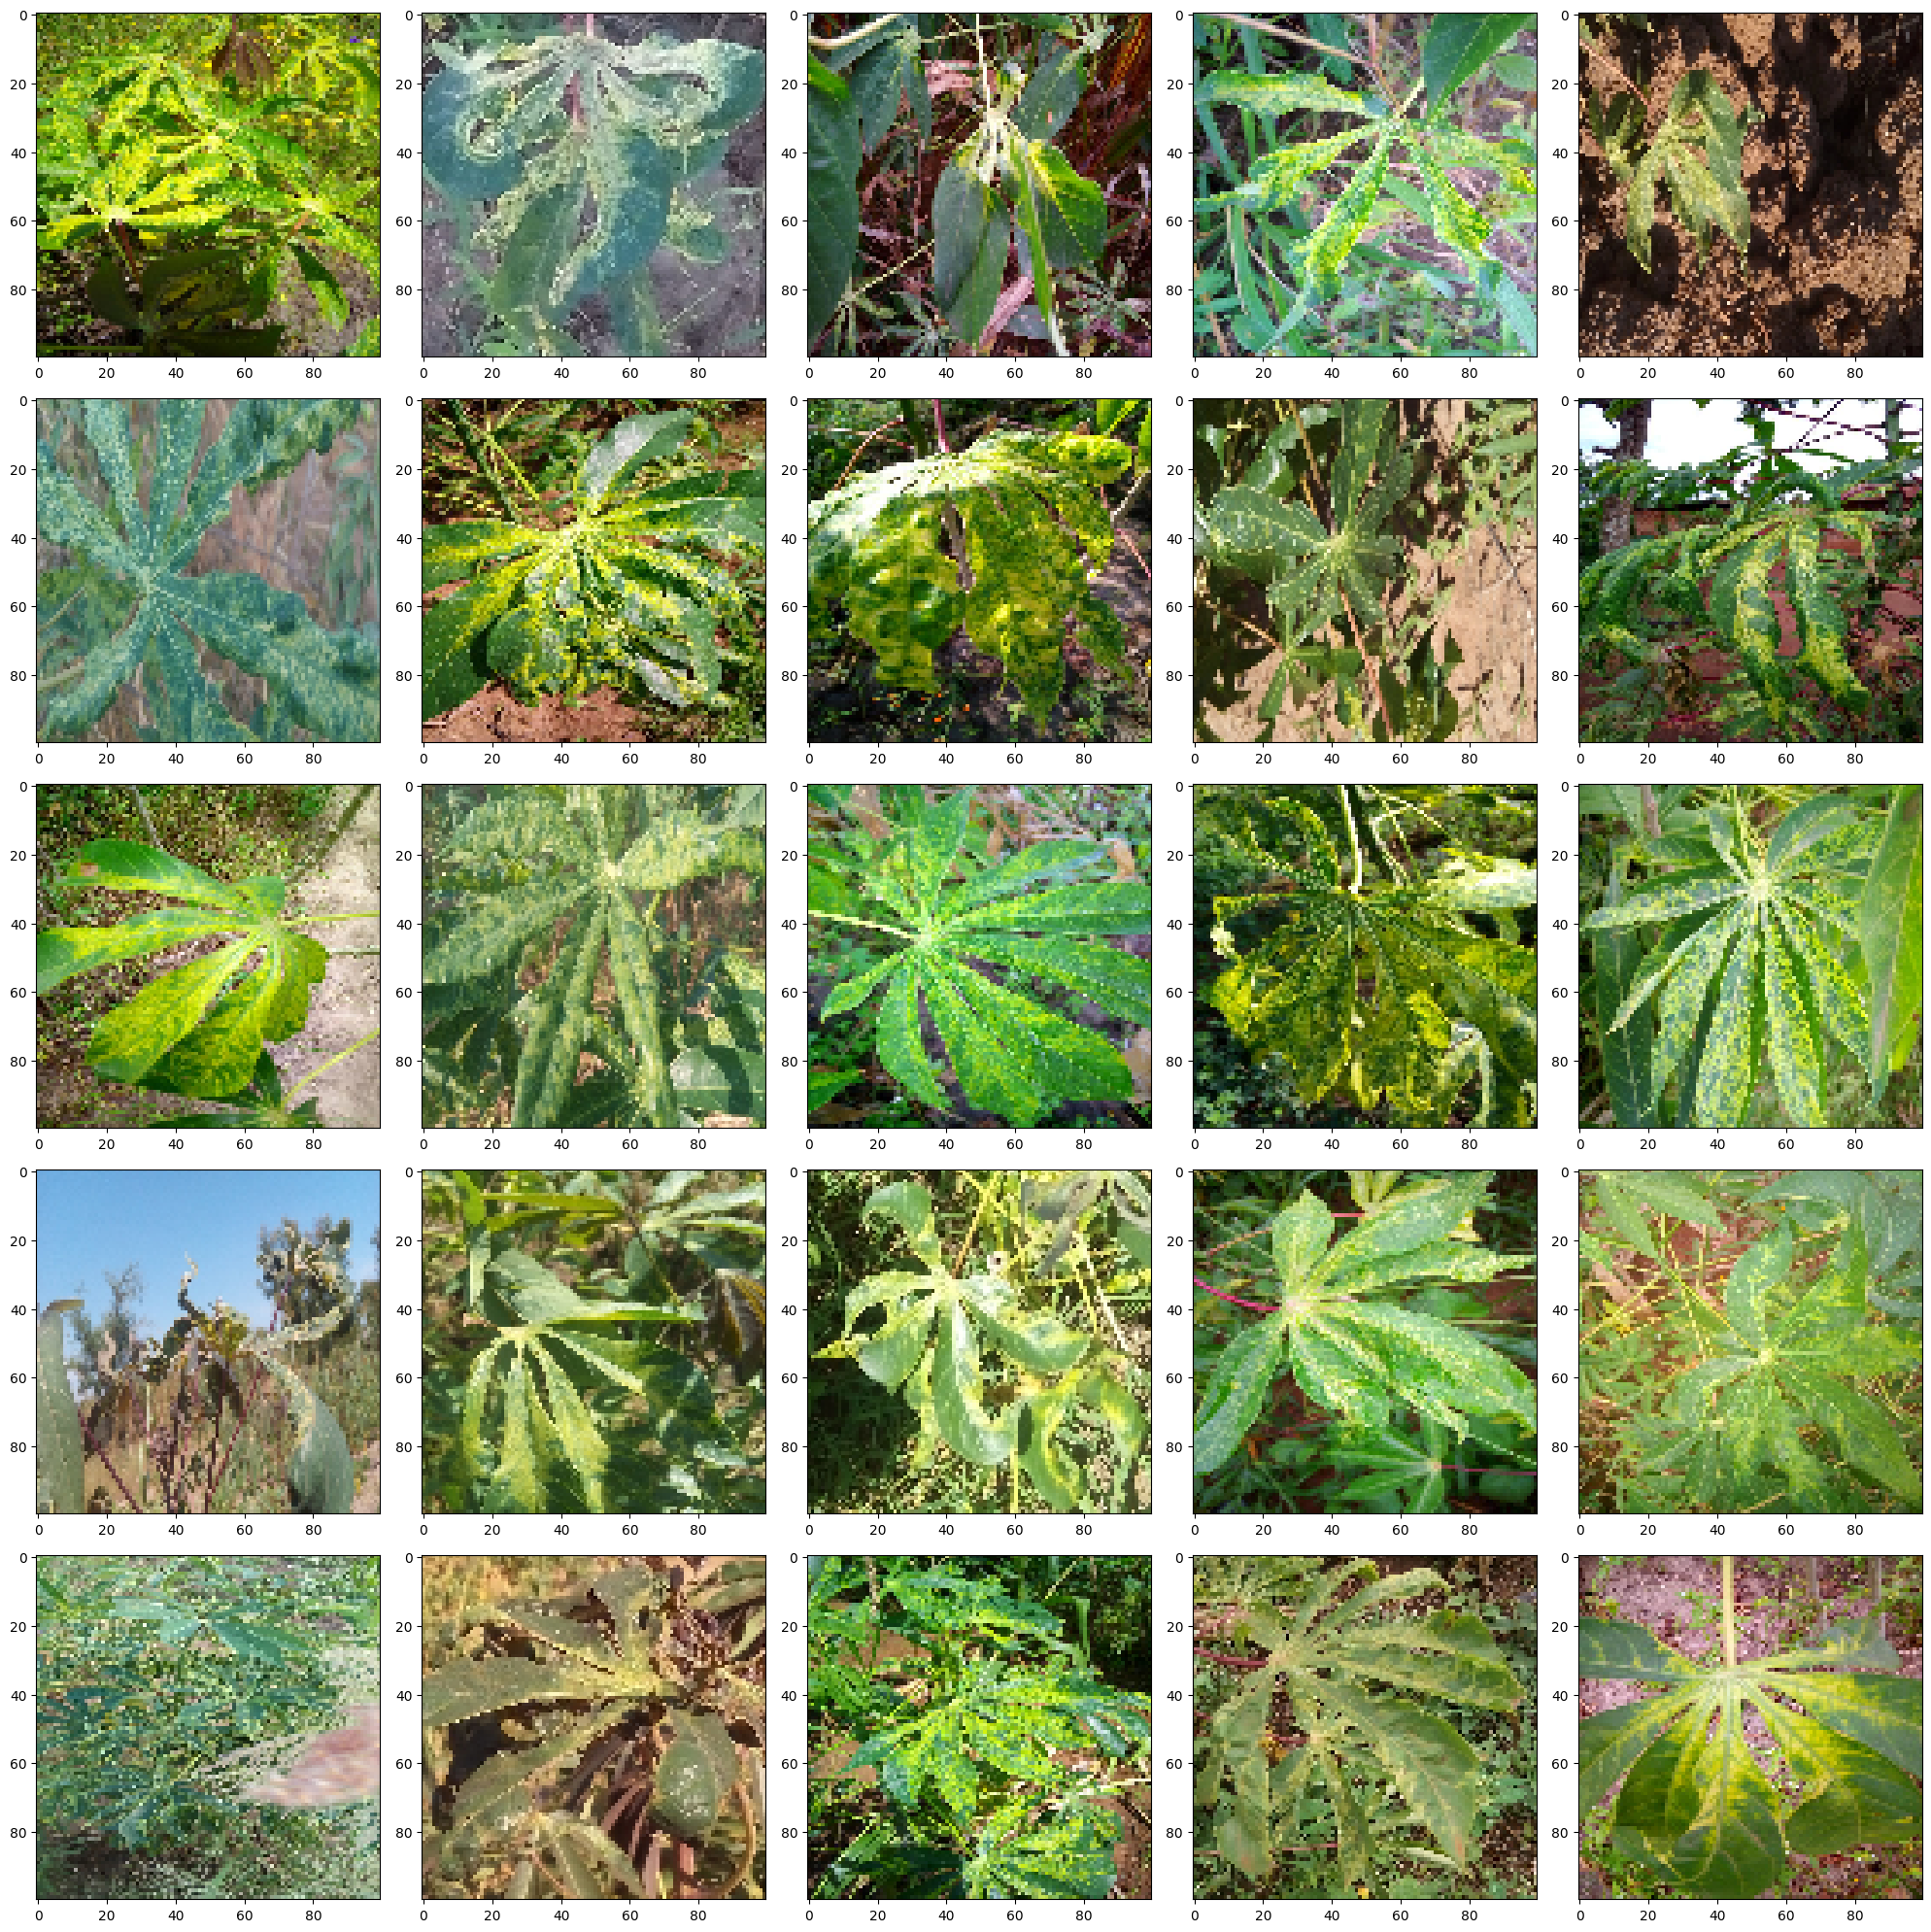

In [22]:
images = [x_train[i] for i in range(25)]
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [23]:
batch_size = 100

In [24]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)
print(x_train.shape)

(1132, 100, 100, 3)
(4524, 100, 100, 3)


In [25]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = datagen.flow(x_val, y_val, batch_size=batch_size)

print(x_val.shape)
print(x_train.shape)

(1132, 100, 100, 3)
(4524, 100, 100, 3)


In [26]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False, # Do not include the ImageNet classifier at the top.
    input_shape=(image_size,image_size,3)
)

In [27]:
# net = MobileNet(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(image_size, image_size, 3)
# )

In [28]:
print(net)

In [29]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(5, activation="softmax", kernel_regularizer=l2(0.01))(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [16]:
# %load_ext tensorboard


# class_names = list(labels)
# def plot_to_image(figure):
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     plt.close(figure)
#     buf.seek(0)

#     digit = tf.image.decode_png(buf.getvalue(), channels=4)
#     digit = tf.expand_dims(digit, 0)

#     return digit

# def plot_confusion_matrix(cm, class_names):
#     figure = plt.figure(figsize=(8, 8))
#     plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
#     plt.title("Confusion matrix")
#     plt.colorbar()
#     tick_marks = np.arange(len(class_names))
#     plt.xticks(tick_marks, class_names, rotation=45)
#     plt.yticks(tick_marks, class_names)

#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
#     threshold = cm.max() / 2.
# #
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

#     return figure

# # Following function will make predictions from the model and log the confusion matrix as an image.
# def log_confusion_matrix(epoch, logs):
#     predictions = np.argmax(model.predict(x_test), axis=1)
#     cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
#     figure = plot_confusion_matrix(cm, class_names=class_names)
#     cm_image = plot_to_image(figure)

#     with file_writer_cm.as_default():
#         tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# # Remove previous log folder
# !rm -fr logs
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# # Run tensorBoard
# %tensorboard --logdir logs

In [17]:
# early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [31]:
# Define callbacks
checkpoint = ModelCheckpoint('model.h5.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
# Fit the model with callbacks
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=val_generator,
    # callbacks=[checkpoint, early_stop]
)

Epoch 1/50
142/142 [==============================] - 11s 77ms/step - loss: 0.2062 - accuracy: 0.9624 - val_loss: 11.3569 - val_accuracy: 0.0839
Epoch 2/50
142/142 [==============================] - 11s 77ms/step - loss: 0.4650 - accuracy: 0.8744 - val_loss: 24.3993 - val_accuracy: 0.0839
Epoch 3/50
142/142 [==============================] - 11s 77ms/step - loss: 0.2552 - accuracy: 0.9458 - val_loss: 4.0341 - val_accuracy: 0.0839
Epoch 4/50
142/142 [==============================] - 11s 77ms/step - loss: 0.1421 - accuracy: 0.9830 - val_loss: 4.3846 - val_accuracy: 0.2429
Epoch 5/50
142/142 [==============================] - 11s 77ms/step - loss: 0.1330 - accuracy: 0.9839 - val_loss: 6.6724 - val_accuracy: 0.2429
Epoch 6/50
142/142 [==============================] - 11s 77ms/step - loss: 0.1269 - accuracy: 0.9836 - val_loss: 5.5678 - val_accuracy: 0.2429
Epoch 7/50
142/142 [==============================] - 11s 77ms/step - loss: 0.1162 - accuracy: 0.9883 - val_loss: 3.5183 - val_accurac

In [49]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model.history.history)

In [50]:
losses.head()

loss  accuracy   val_loss  val_accuracy
0  0.206217  0.962423  11.356932      0.083922
1  0.464976  0.874447  24.399332      0.083922
2  0.255241  0.945844   4.034133      0.083922
3  0.142145  0.982980   4.384602      0.242933
4  0.133013  0.983864   6.672352      0.242933

<Axes: title={'center': 'Training acuration and Validation Graph'}>

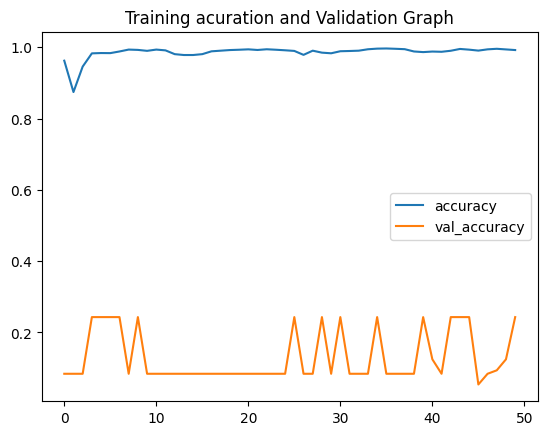

In [51]:
losses[['accuracy','val_accuracy']].plot(title='Training acuration and Validation Graph')

<Axes: title={'center': 'Training and Validation Loss Graph'}>

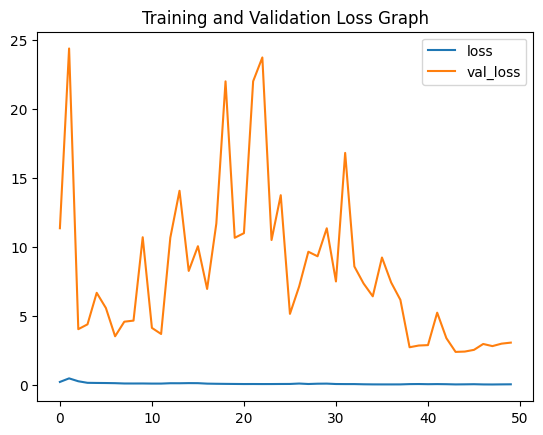

In [52]:
losses[['loss','val_loss']].plot(title='Training and Validation Loss Graph')

In [37]:
model.metrics_names

['loss', 'accuracy']

In [38]:
print(model.metrics_names)
print(model.evaluate(x_test,y_test,verbose=2))

['loss', 'accuracy']
118/118 - 2s - loss: 1.9934 - accuracy: 0.1698 - 2s/epoch - 19ms/step
[1.993446946144104, 0.169846311211586]


In [39]:
predictions = model.predict(x_test)

118/118 [==============================] - 2s 16ms/step


In [40]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

118/118 [==============================] - 2s 16ms/step
[3 3 3 ... 3 3 2]


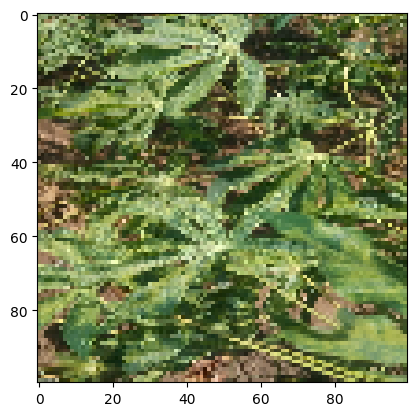

In [41]:
image = x_test[16]
plt.imshow(image)

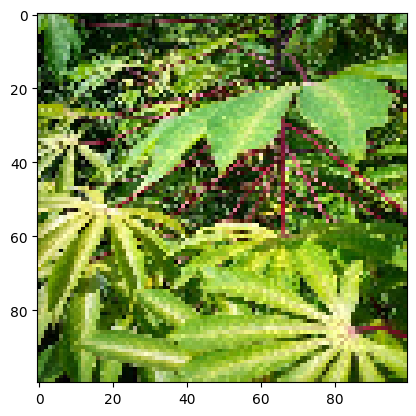

In [42]:
image = x_test[9]
plt.imshow(image)

In [43]:
# rounded_predictions = np.round(predictions)
# predicted_classes = np.argmax(rounded_predictions, axis=1)
# print(classification_report(y_test, predicted_classes))

118/118 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.17      0.29      3774

    accuracy                           0.17      3774
   macro avg       0.25      0.04      0.07      3774
weighted avg       1.00      0.17      0.29      3774



C:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


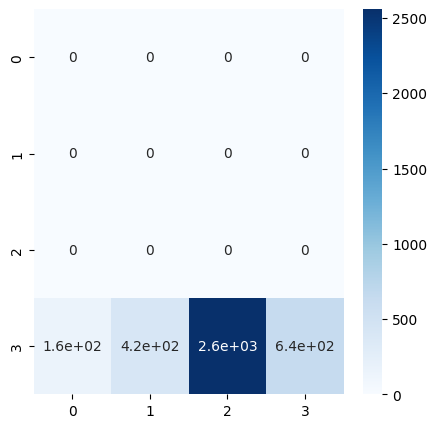

In [44]:
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (5, 5))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

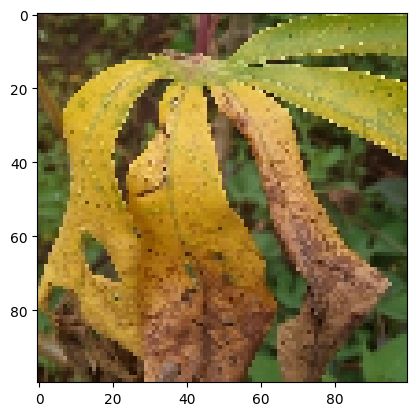

In [45]:
image = x_test[44]
plt.imshow(image)

In [46]:
test_index = 44

test_image = np.expand_dims(x_test[test_index], axis=0)

prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)

print(f"Predicted Class: {labels[predicted_class]}")

1/1 [==============================] - 0s 62ms/step
Predicted Class: cbsd


1/1 [==============================] - 0s 16ms/step


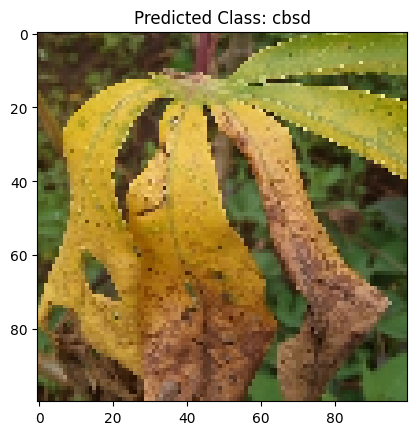

1/1 [==============================] - 0s 16ms/step


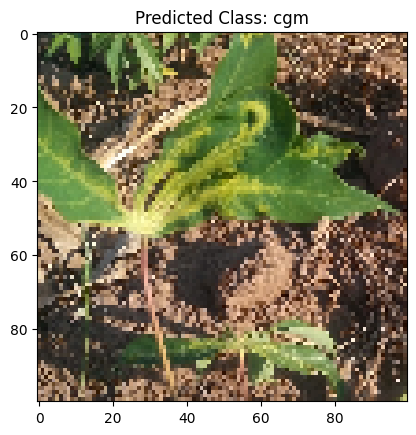

1/1 [==============================] - 0s 17ms/step


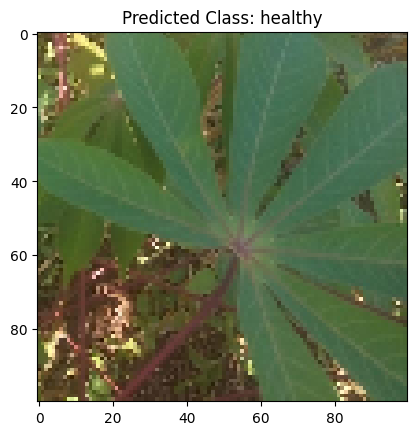

In [47]:
import matplotlib.pyplot as plt

test_indices = [44, 55, 66]  # Ganti dengan indeks gambar yang ingin di uji

for test_index in test_indices:
    test_image = np.expand_dims(x_test[test_index], axis=0)

    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)

    plt.imshow(x_test[test_index])
    plt.title(f"Predicted Class: {labels[predicted_class]}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


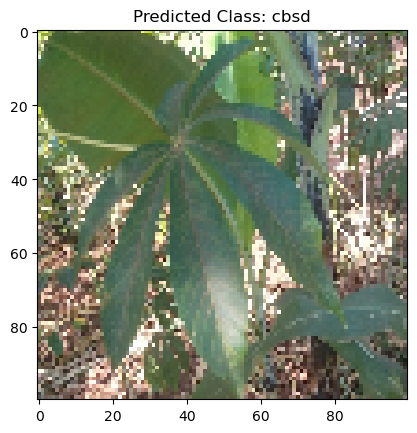

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


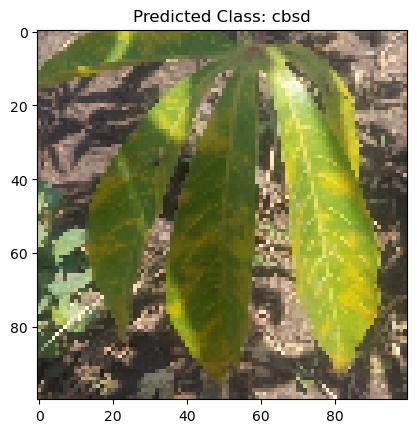

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


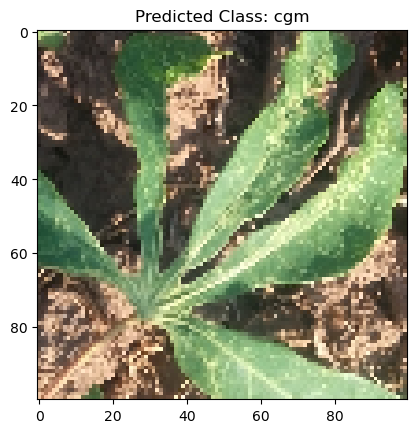

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


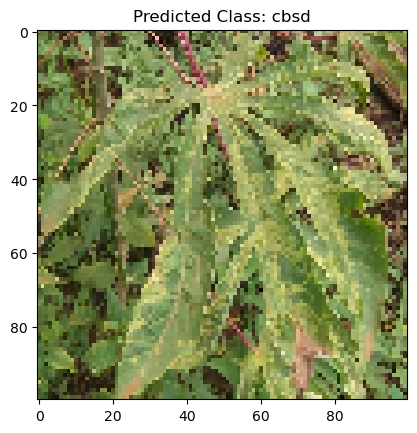

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


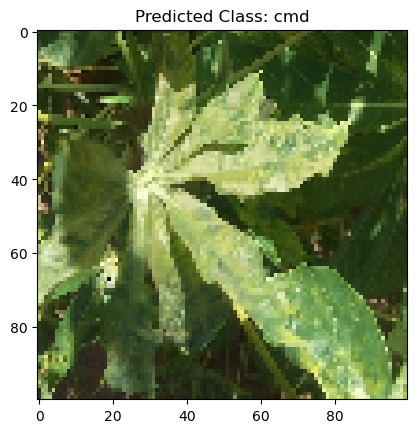

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


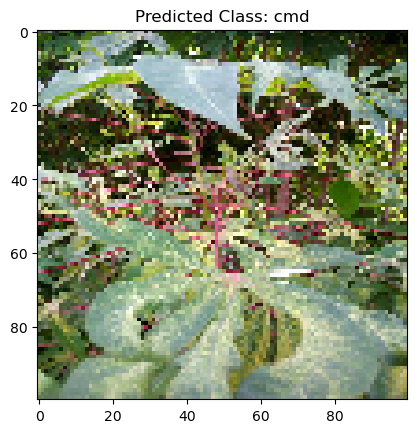

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


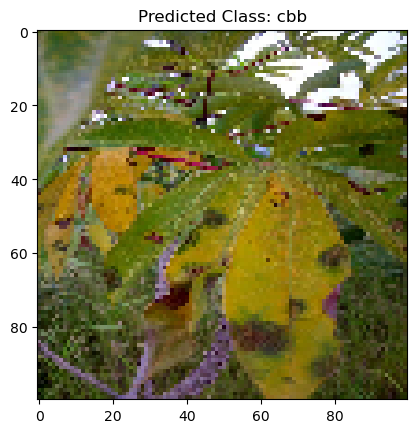

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


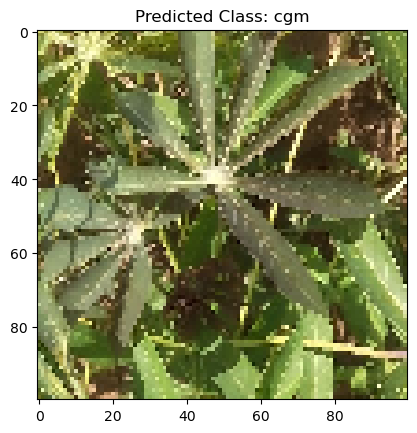

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


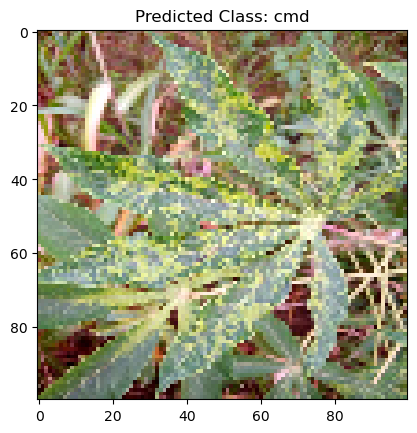

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


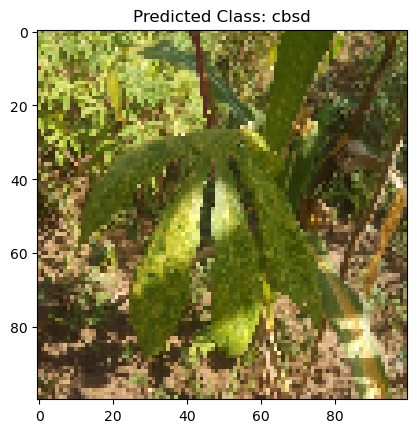

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


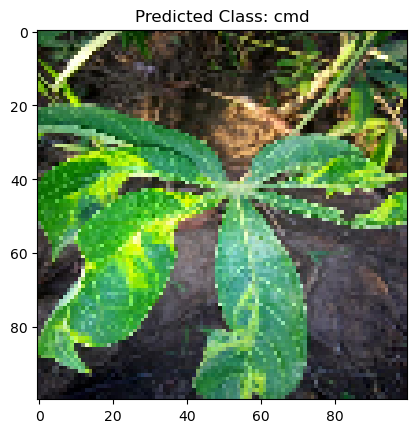

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


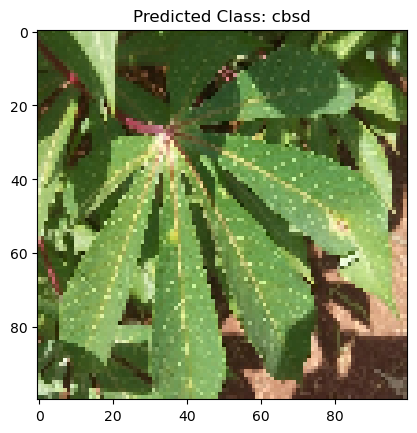

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


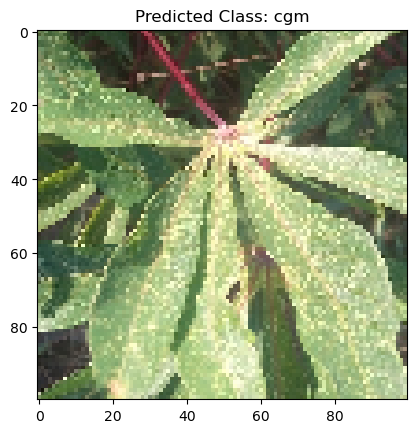

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


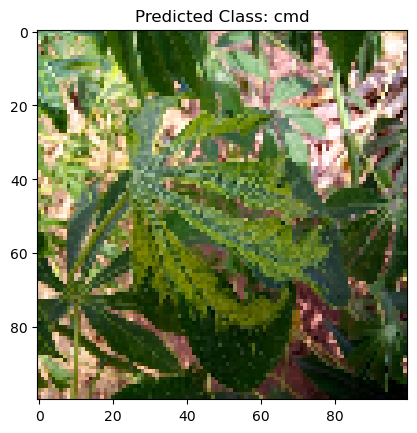

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


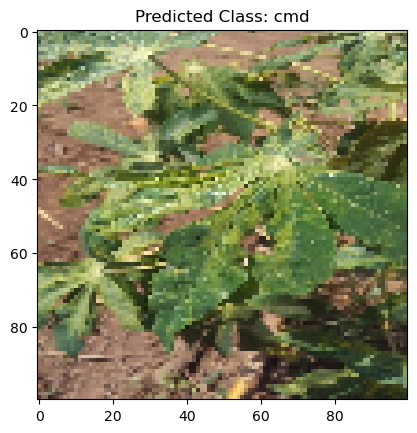

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


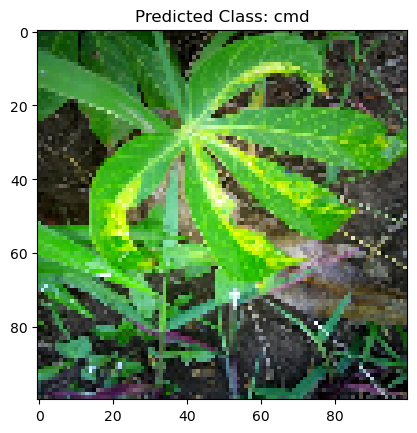

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


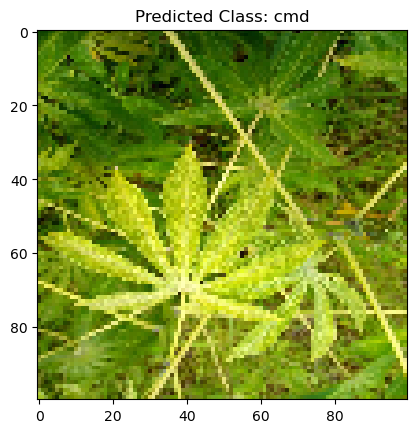

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


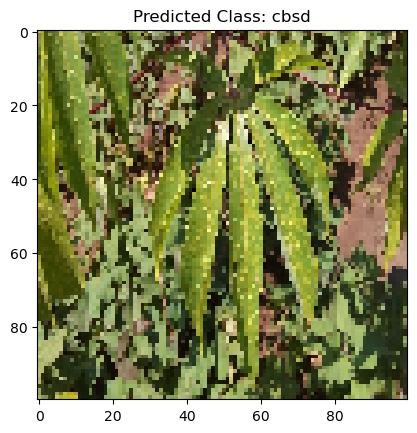

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


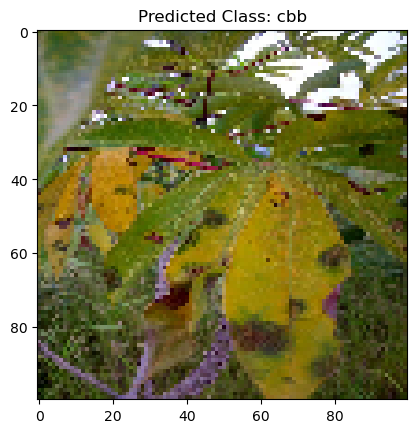

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


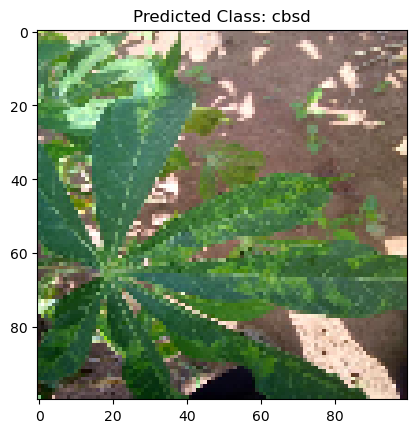

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


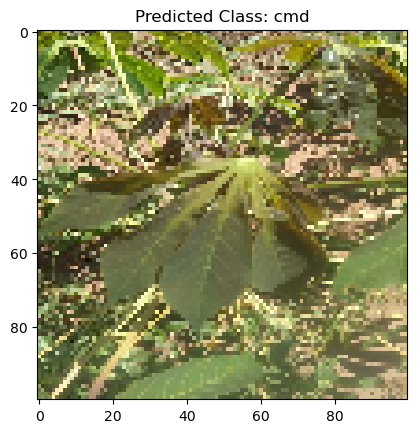

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


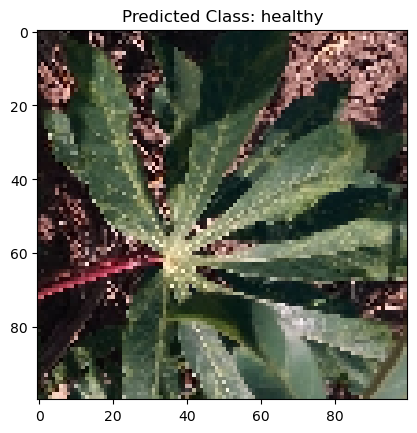

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


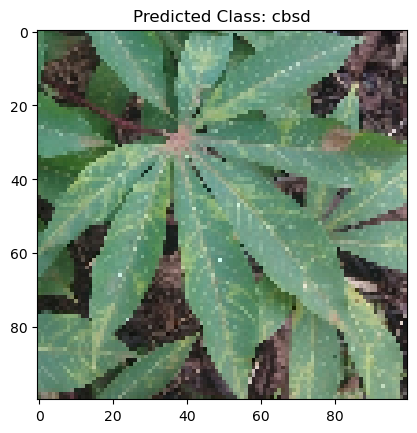

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


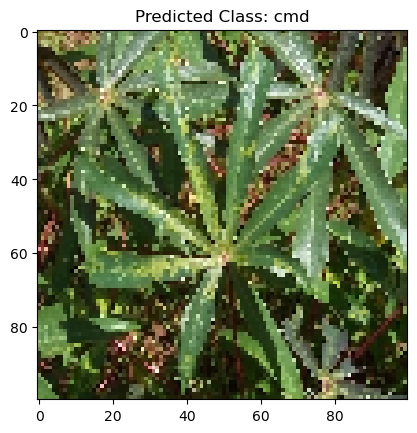

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


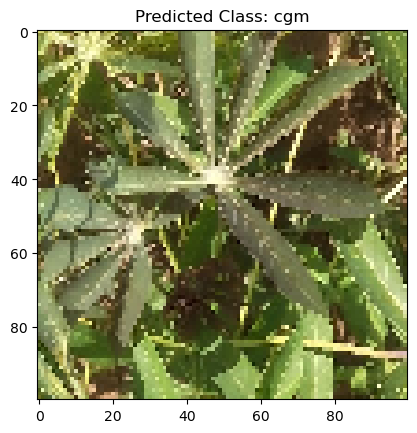

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


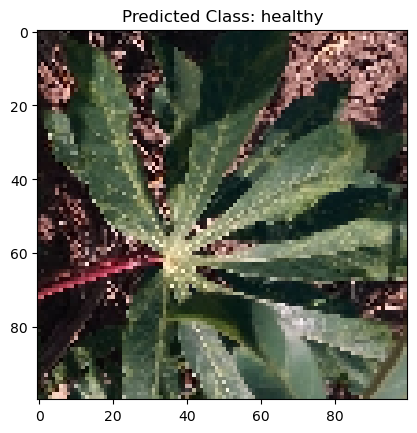

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


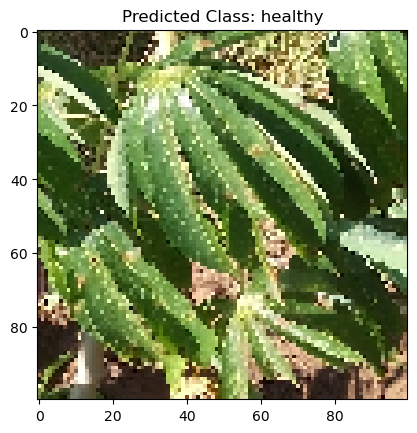

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


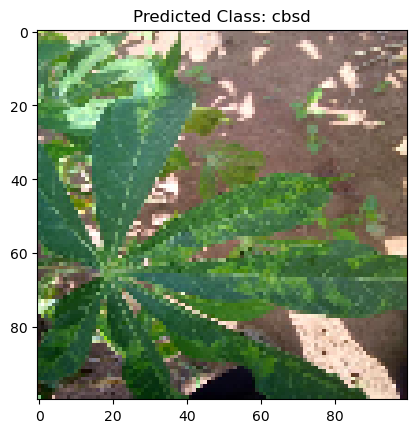

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


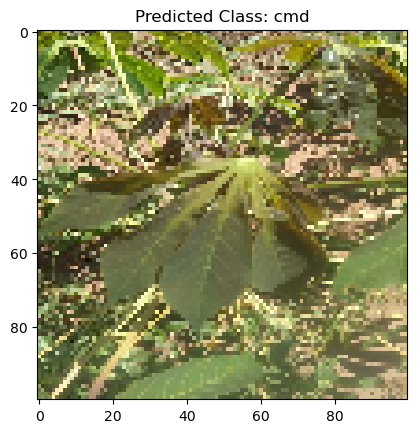

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


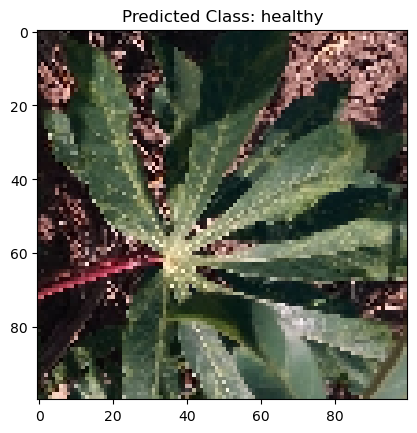

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


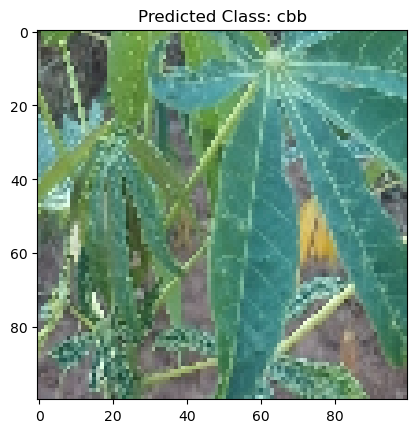

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


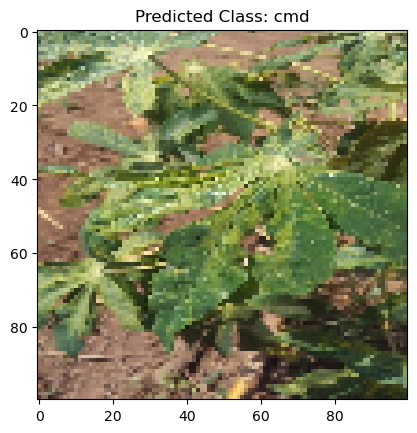

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


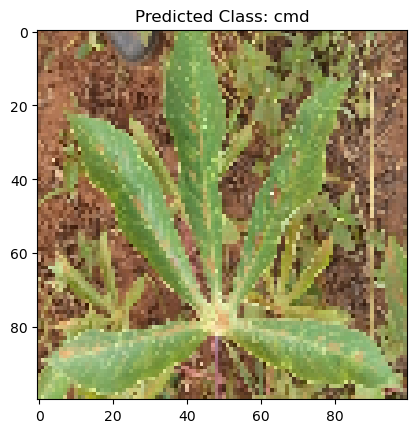

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


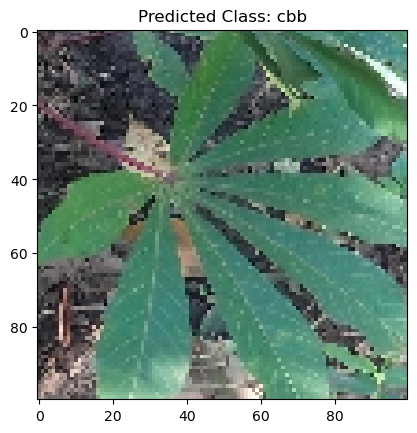

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


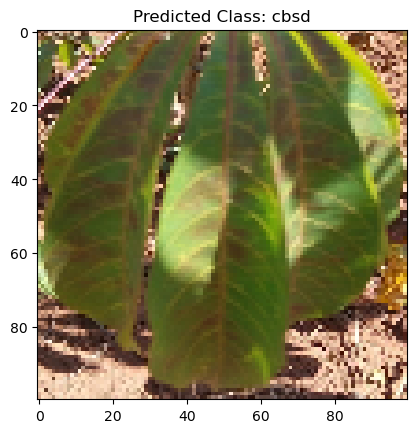

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


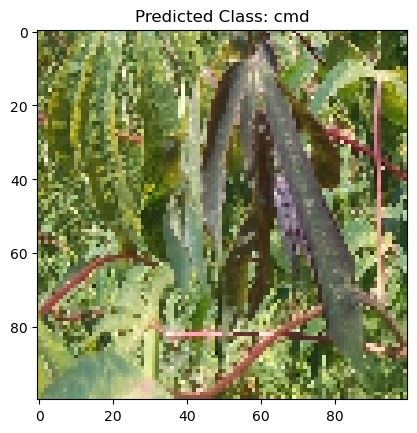

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


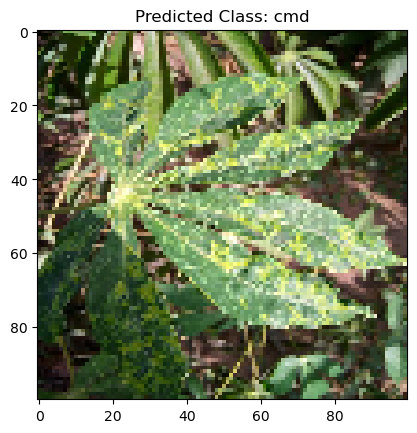

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


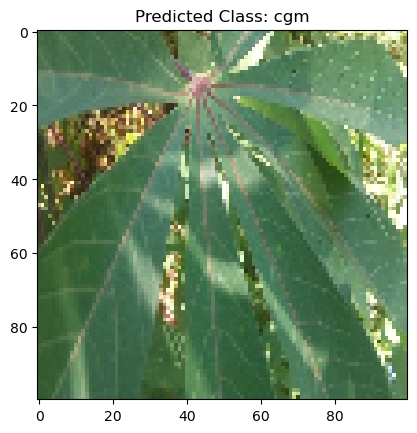

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


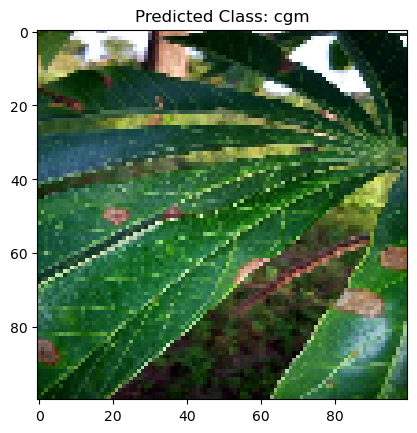

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


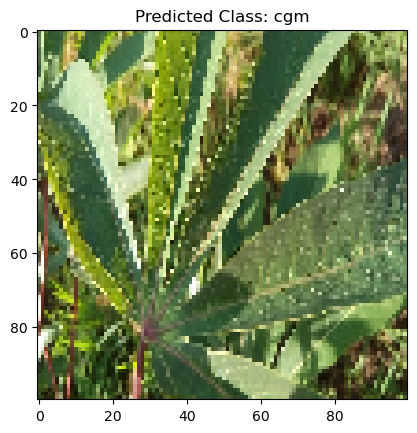

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


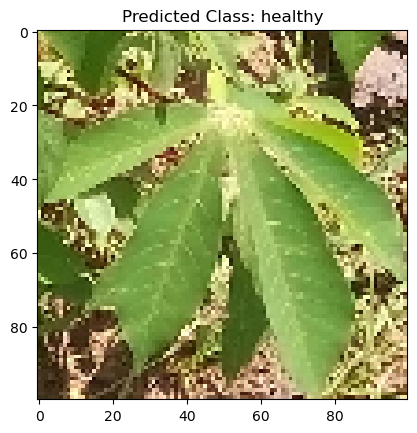

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


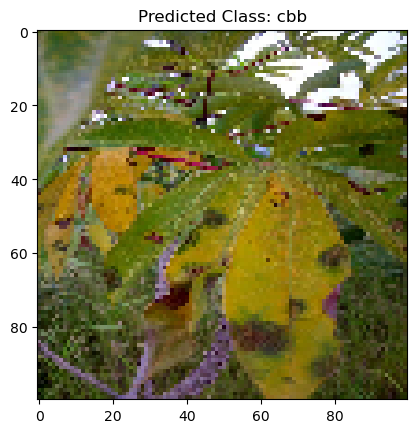

In [35]:
test_indices = [877,988,558,992,887,568,76,46,344,57,88,334,64,22,67,87,234,45,76,23,56,78,53,13,46,78,32,23,56,78,34,67,656,39,97,24,82,68,27,255,36,76]  # Ganti dengan indeks gambar yang ingin di uji

for test_index in test_indices:
    test_image = np.expand_dims(x_test[test_index], axis=0)

    prediction = model.predict(test_image)
    predicted_class = np.argmax(prediction)

    plt.imshow(x_test[test_index])
    plt.title(f"Predicted Class: {labels[predicted_class]}")
    plt.show()